In [24]:
import h5py
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy import units as u
import astropy.coordinates as coord

In [2]:
from matplotlib import rc, rcParams
rc_params = {'axes.labelsize': 20,
             'axes.titlesize': 20,
             'axes.linewidth':2,
             'font.size': 20,
             'lines.linewidth' : 2.5,
             'legend.fontsize': 15,
             'xtick.labelsize': 20,
             'ytick.labelsize': 20
            }
rcParams.update(rc_params)

In [34]:
def reading_shape_data(file_data, params, shear_flag="unsheared", start=0, end=1000000):
    """
    file_data: open file data to the shape catalog
    params:   name of the parameters to be read
    shear_flag: `unsheared` or `sheared_1m`, `sheared_1p`, `sheared_2p`, `sheared_2m` (default is sheared)
    start:    index to start from (int)
    end:      index to end at (int)
    """
    data = {}
    for param_key in params:
        data[param_key] = file_data["catalog"][shear_flag][param_key][start:end]
        
    return pd.DataFrame(data)
    
def reading_DNF_redshift(file_data, params, shear_flag="unsheared", start=0, end=1000000):
    """
    file_data: open file data to the shape catalog
    params:   name of the parameters to be read
    shear_flag: `unsheared` or `sheared_1m`, `sheared_1p`, `sheared_2p`, `sheared_2m` (default is sheared)
    start:    index to start from (int)
    end:      index to end at (int)
    """
    data = {}
    for param_key in params:
        data[param_key] = file_data["catalog"][shear_flag][param_key][start:end]
        
    return pd.DataFrame(data)

def reading_lens_params(filename, frac=0.01):
    
    lens_params = ['coadd_object_id', 'ra', 'dec', 'zredmagic', 'lum_z']
    
    data = fits.getdata(filename)
    header = fits.getheader(filename)
    
    # selecting a fraction 
    idx = np.random.random(size=data["lum_z"].size)<frac
    
    data_dict = {}
    for key in lens_params:
        data_dict[key] = data[key]
    return data_dict

In [25]:
def reading_data_sources(start, end):
    """
    start:
    end: 
    """
    # The parameters needed to computing differential surface density
    shape_params = ['coadd_object_id', 'ra', 'dec', 'e_1', 'e_2',\
                'snr', 'weight', 'flags', 'size_ratio', 'T',\
                'R11', 'R12', 'R21', 'R22']
    redshift_params = ['coadd_object_id', 'zmc_sof', 'zmean_sof']
    
    data1 = reading_shape_data(file_data=shape_file_data, params=shape_params, start=start, end=end)
    data2 = reading_shape_data(file_data=redshift_file_data, params=redshift_params, start=start, end=end)
    data1["zmc_sof"] = data2["zmc_sof"]
    data1["zmean_sof"] = data2["zmean_sof"]
    
    # Metacal selection
    data = data1
    flags = 0
    snr_th_lower = 10
    snr_th_upper = 1000
    size_ratio = 0.5
    T = 10

    idx = np.array(data["flags"] == flags) & np.array(data["snr"] > snr_th_lower) & \
                    np.array(data["snr"] < snr_th_upper) & np.array(data["size_ratio"] > size_ratio) & \
                    np.array(data["T"] < T)
    
    data_selected = dict()
    for key in list(data.keys()):
        data_selected[key] = data[key].values[idx]
        
    return data_selected

In [26]:
file = "/home/idies/workspace/Temporary/surhudm/scratch/DES/DESY3_metacal_v03-004.h5"
file_z = "/home/idies/workspace/Temporary/surhudm/scratch/DES/DESY3_GOLD_2_2.1_DNF.h5"
shape_file_data = h5py.File(file, "r")
redshift_file_data = h5py.File(file_z, "r")

In [16]:
t0 = time.time()
Nsize = shape_file_data["catalog"]["unsheared"]["e_1"].shape[0]
chunksize = 50000000
for ii in range(0, Nsize//chunksize + 1):
    start = ii*chunksize
    end = (ii+1)*chunksize
    data_selected = reading_data_sources(start=start, end=end) 
    break
tf = time.time()
print("Time taken: %f seconds!"%(tf-t0))

Time taken: 81.865257 seconds!


In [17]:
data_selected

{'coadd_object_id': array([333409903, 333409662, 333409498, ..., 190819514, 190819486,
        190819449]),
 'ra': array([45.00143657, 44.99728215, 45.00296337, ...,  5.13412097,
         5.13325006,  5.15373008]),
 'dec': array([ 0.00370688,  0.01045192,  0.015668  , ..., -0.06658283,
        -0.0653278 , -0.06381856]),
 'e_1': array([ 0.49758885,  0.1619972 , -0.33943113, ...,  0.14221345,
        -0.00605006, -0.3003568 ]),
 'e_2': array([-0.46418295,  0.0837993 ,  0.51807028, ...,  0.2830388 ,
         0.2495639 , -0.16142858]),
 'snr': array([ 24.92721718,  32.97813787,  20.73546637, ..., 271.18102459,
        146.72089469,  21.33209567]),
 'weight': array([35.10233195, 50.7918021 , 30.65967688, ..., 74.88398951,
        64.80081738, 33.21429983]),
 'flags': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'size_ratio': array([1.415153  , 2.73476535, 1.17707514, ..., 1.18247246, 0.6946768 ,
        1.51304448]),
 'T': array([0.54702584, 1.05471941, 0.45944809, ..., 0.54356641, 0.3410

Text(0, 0.5, 'DEC [degrees]')

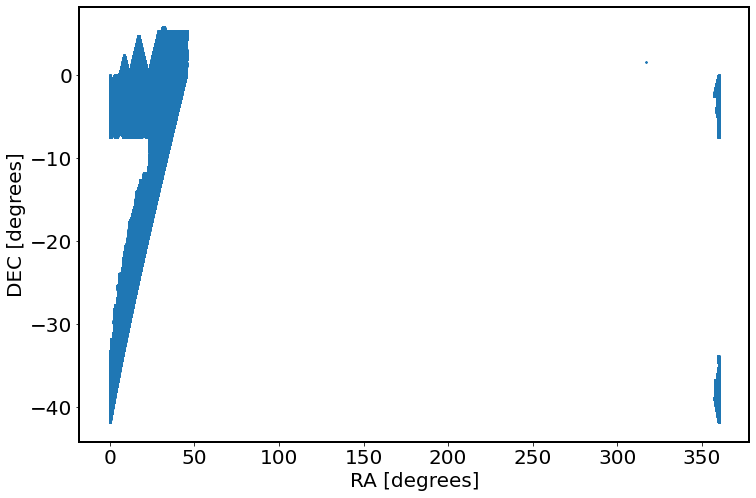

In [18]:
plt.figure(figsize=(12, 8))
plt.scatter(data_selected["ra"], data_selected["dec"], s=1)
#plt.xlim(0, 50)
plt.xlabel(r"RA [degrees]")
plt.ylabel(r"DEC [degrees]")

In [19]:
ra = coord.Angle(data_selected['ra']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(data_selected['dec']*u.degree)

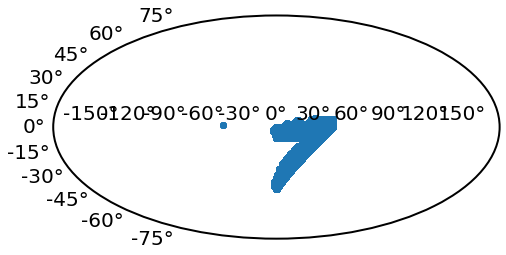

In [20]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian)

In [27]:
fname = "/home/idies/workspace/Temporary/surhudm/scratch/DES/y3a2_gold2.2.1_redmagic_highdens.fits"
lens_data = reading_lens_params(filename=fname)

In [28]:
lens_data

FITS_rec([(333778746,  44.67838692,  0.45266183, 0.18580292, 0.00966049, 17.972324, 0.5219434, 0.18297455, 0.19197454, 0.18867454, 0.17077455, 0.85958451, 1),
          (333776914,  44.60102894,  0.50446138, 0.2415814 , 0.01110072, 18.165049, 0.7844884, 0.2466423 , 0.2684423 , 0.2398423 , 0.2460423 , 0.92532575, 1),
          (333770383,  44.83928625,  0.67651361, 0.41708368, 0.02686991, 18.948288, 1.2985103, 0.39401835, 0.42901838, 0.42321837, 0.42531836, 0.        , 2),
          ...,
          (178661198, 317.13103508, -1.82213193, 0.59533674, 0.01897945, 19.718138, 1.3940973, 0.5933261 , 0.5956261 , 0.6009261 , 0.5896261 , 1.04191411, 3),
          (178659622, 317.10415192, -1.80486234, 0.15787321, 0.00575691, 16.635256, 1.2578355, 0.16779096, 0.16499096, 0.14919096, 0.15689096, 0.99582094, 1),
          (178659905, 317.07078067, -1.8007217 , 0.62382716, 0.02227375, 19.993147, 1.2102404, 0.58827317, 0.6371732 , 0.58497316, 0.60047317, 1.00057578, 3)],
         dtype=(numpy.record, 

Text(0, 0.5, '$L/L_{*}$')

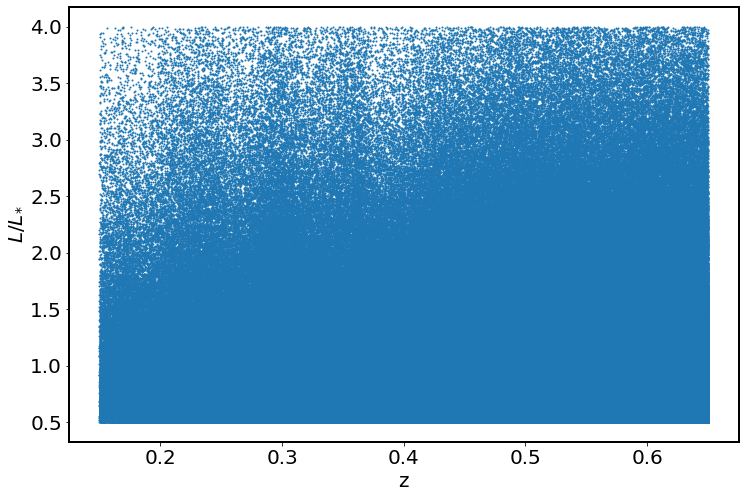

In [29]:
plt.figure(figsize=(12, 8))
#frac
plt.scatter(lens_data["zredmagic"], lens_data["lum_z"], s=1)
plt.xlabel('z')
plt.ylabel(r'$L/L_{*}$')

Text(0, 0.5, '$L/L_{*}$')

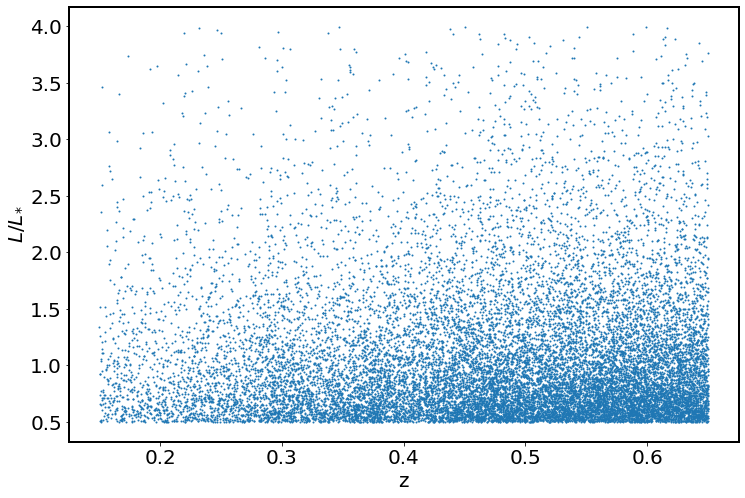

In [32]:
idx = np.random.random(size=lens_data["lum_z"].size)<0.01
plt.figure(figsize=(12, 8))
plt.scatter(lens_data["zredmagic"][idx], lens_data["lum_z"][idx], s=1)
plt.xlabel('z')
plt.ylabel(r'$L/L_{*}$')

### Parameters Required for surface density

Shear compoenents:$\gamma_1, \gamma_2$

Position angle of the galaxy with respect to halo center: $\phi$

Source and lens redshifts: $z_l, z_s$

Galaxy locations: $\alpha, \delta$

Shear and selection response: $\mathcal{R}, \mathcal{R}_s$

Squared inverse of the measured shear uncertainty: $$